In [31]:
import pickle
import gzip
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math
from transformers import AutoConfig
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_metric
import numpy as np
from functools import cmp_to_key

In [2]:
vid_batch_size = 8
slrt_input_len = 200
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [3]:
class PhoenixDataset(Dataset):
    def __init__(self, annotations_path):
        
        with gzip.open(annotations_path, 'rb') as f:
            self.annotations = pickle.load(f)
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        
        #vid = torchvision.io.read_video(os.path.join(self.vid_dir, self.vid_files[index]))[0] # vid = time x height x width x channels
        #vid = vid[:max_vid_len]
        #vid_len = vid.shape[0]
        #vid = F.interpolate(vid.permute(0, 3, 1, 2), size=self.im_size)
        #vid = IT.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(vid.type(torch.FloatTensor))
        #vid = torch.cat((vid, torch.zeros(max_vid_len - vid.shape[0], *vid.shape[1:])), dim=0)
        sign, gloss, text = self.annotations[index]['sign'], self.annotations[index]['gloss'], self.annotations[index]['text']
        sign = sign[:slrt_input_len]
        sign = torch.cat([sign, torch.zeros(slrt_input_len - sign.shape[0], *sign.shape[1:])], dim=0)

        return (sign, gloss, text)

In [4]:
phoenix_train = PhoenixDataset(
    annotations_path = r"C:\Sign-Language-Recognition\Datasets\PHOENIX14T\phoenix14t.pami0.train",
)

indices = np.random.choice(len(phoenix_train), 500, replace=False)
phoenix_train_small = Subset(phoenix_train, indices)

phoenix_val = PhoenixDataset(
    annotations_path = r"C:\Sign-Language-Recognition\Datasets\PHOENIX14T\phoenix14t.pami0.dev",
)

phoenix_test = PhoenixDataset(
    annotations_path = r"C:\Sign-Language-Recognition\Datasets\PHOENIX14T\phoenix14t.pami0.test",
)

phoenix_train_loader = DataLoader(dataset=phoenix_train, batch_size=vid_batch_size, shuffle=True, num_workers=0)
phoenix_train_small_loader = DataLoader(dataset=phoenix_train_small, batch_size=vid_batch_size, shuffle=True, num_workers=0)
phoenix_val_loader = DataLoader(dataset=phoenix_val, batch_size=vid_batch_size, shuffle=True, num_workers=0)
phoenix_test_loader = DataLoader(dataset=phoenix_test, batch_size=vid_batch_size, shuffle=True, num_workers=0)

In [5]:
len(phoenix_train), len(phoenix_train_small), len(phoenix_val), len(phoenix_test)

(7096, 500, 519, 642)

In [6]:
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
vocab_size = len(t5_tokenizer)
ctc_loss = nn.CTCLoss(blank=vocab_size, zero_infinity=True)
vocab_size

32100

In [7]:
def initialize_model_and_opt(config):
    hf_config = AutoConfig.from_pretrained('t5-small')
    
    if "dropout_rate" in config.keys():
        hf_config.dropout_rate = config['dropout_rate']
    
    if "layer_norm_epsilon" in config.keys():
        hf_config.layer_norm_epsilon = config['layer_norm_epsilon']
    
    model = T5ForConditionalGeneration.from_pretrained("t5-small", config=hf_config).to(device)
    
    frame_to_enc = nn.Linear(1024, 512).to(device)
    enc_to_gloss_probs = nn.Sequential(
        nn.Linear(512, vocab_size + 1),
        nn.LogSoftmax(dim = -1)
    ).to(device)
    
    extra_layers = {
        'frame_to_enc': frame_to_enc,
        'enc_to_gloss_probs': enc_to_gloss_probs,
    }
    opt = torch.optim.AdamW([
        {'params': model.parameters(), 'lr': config['model-lr']},
        {'params': enc_to_gloss_probs.parameters(), 'lr': config['extra-layer-lr']},
        {'params': frame_to_enc.parameters(), 'lr': config['extra-layer-lr']}
    ])
    
    return model, extra_layers, opt

In [8]:
bleu = load_metric("bleu")

In [9]:
def evaluate(model, frame_to_enc, data_loader, metric):
    progress = tqdm(range(len(data_loader)))
    model.eval()
    for s, g, t in data_loader:
        s = s.to(device)
        frame_embeds = frame_to_enc(s.view(-1, 1024)).view(len(s), 200, 512)
        translations_ids = t5_tokenizer(list(t), return_tensors='pt', padding='max_length', max_length=200).input_ids.to(device)
        outputs = model.generate(inputs_embeds=frame_embeds)
        
        predictions = [s.split(" ") for s in t5_tokenizer.batch_decode(outputs, skip_special_tokens=True)]
        references = [[s.split(" ")] for s in t]
        metric.add_batch(predictions=predictions, references=references)
        
        progress.update(1)
    
    return metric.compute()

In [10]:
def train(model, extra_layers, optimizer, tokenizer, recog_loss_weight, dataloaders, n_epochs, save_folder, eval_every=300, should_print=True):
    trans_loss_history = {}
    recog_loss_history = {}
    total_loss_history = {}
    train_bleu_history = {}
    val_bleu_history = {}
    test_bleu_history = {}
    
    train_loader, train_small_loader, val_loader, test_loader = dataloaders['train'], dataloaders['train-small'], dataloaders['val'], dataloaders['test']
    frame_to_enc = extra_layers['frame_to_enc']
    enc_to_gloss_probs = extra_layers['enc_to_gloss_probs']
    
    for epoch in tqdm(range(n_epochs), desc = 'Epochs'):
        train_progress = tqdm(range(len(train_loader)), desc = 'Batches processed')
        for i, batch in enumerate(train_loader):
            optimizer.zero_grad()
            sign, gloss, text = batch
            sign = sign.to(device)
            frame_embeds = frame_to_enc(sign.view(-1, 1024)).view(len(sign), 200, 512)
            translations_ids = tokenizer(list(text), return_tensors='pt', padding='max_length', max_length=200).input_ids.to(device)
            outputs = model(inputs_embeds=frame_embeds, labels=translations_ids)

            gloss_probs = enc_to_gloss_probs(outputs.encoder_last_hidden_state.view(-1, 512)).view(vid_batch_size, 200, vocab_size+1).permute(1, 0, 2)
            input_lengths = torch.full(size=(vid_batch_size,), fill_value=200, dtype=torch.long).to(device)
            glosses = tokenizer(list(gloss), return_tensors='pt', padding='max_length', max_length=200)
            gloss_ids = glosses.input_ids.to(device)
            gloss_lengths = torch.sum(glosses.attention_mask, dim = -1).to(device)
            recog_loss = ctc_loss(gloss_probs, gloss_ids, input_lengths, gloss_lengths)

            loss = (1 - recog_loss_weight) * outputs.loss + recog_loss_weight * recog_loss
    #        loss = outputs.loss
            loss.backward()
            optimizer.step()
            
            trans_loss_history[str(epoch) + '-' + str(i)] = outputs.loss.item()
            recog_loss_history[str(epoch) + '-' + str(i)] = recog_loss.item()
            total_loss_history[str(epoch) + '-' + str(i)] = loss.item()
                
            if i % eval_every == 0:
                model.eval()
                
                train_bleu_history[str(epoch) + '-' + str(i)] = evaluate(model, frame_to_enc, train_small_loader, bleu)
                val_bleu_history[str(epoch) + '-' + str(i)] = evaluate(model, frame_to_enc, val_loader, bleu)
                test_bleu_history[str(epoch) + '-' + str(i)] = evaluate(model, frame_to_enc, test_loader, bleu)
                model.save_pretrained(os.path.join(save_folder, str(epoch) + '-' + str(i), 'model'))
                torch.save(frame_to_enc, os.path.join(save_folder, str(epoch) + '-' + str(i), 'frame_to_enc'))
                torch.save(enc_to_gloss_probs, os.path.join(save_folder, str(epoch) + '-' + str(i), 'enc_to_gloss_probs'))

                if should_print:
                    print("Epoch:", epoch, "Iteration:", i)
                    print("Train bleu: {:.2%}".format(train_bleu_history[str(epoch) + '-' + str(i)]['bleu']))
                    print("Val bleu: {:.2%}".format(val_bleu_history[str(epoch) + '-' + str(i)]['bleu']))
                    print("Test bleu: {:.2%}".format(test_bleu_history[str(epoch) + '-' + str(i)]['bleu']))
                    print("Translation loss: {:.3f}".format(outputs.loss.item()))
                    print("Recognition loss: {:.3f}".format(recog_loss.item()))
                    print("\n")
                    print("Gloss:", gloss[0])
                    print("Translation:", text[0])
                    print("Predicted translation:", tokenizer.decode(model.generate(inputs_embeds=frame_embeds)[0]))
                    print("========================================================================================")
                model.train()

            train_progress.update(1)
    
    histories = {
        'trans_loss': trans_loss_history,
        'recog_loss': recog_loss_history,
        'total_loss': total_loss_history,
        'train_bleu': train_bleu_history,
        'val_bleu': val_bleu_history,
        'test_bleu': test_bleu_history,
    }
    return histories

In [93]:
configs = {
    1: {
        'recog_loss_weight': 0.01,
        'dropout_rate': 0.1,
        'model-lr': 1e-4,
        'extra-layer-lr': 5e-3
    },
    
    2: {
        'recog_loss_weight': 0.01,
        'dropout_rate': 0.25,
        'model-lr': 1e-4,
        'extra-layer-lr': 5e-3
    },
    
    3: {
        'recog_loss_weight': 0.05,
        'dropout_rate': 0.1,
        'model-lr': 1e-4,
        'extra-layer-lr': 5e-3
    },
    
    4: {
        'recog_loss_weight': 0.1,
        'dropout_rate': 0.1,
        'model-lr': 1e-4,
        'extra-layer-lr': 5e-3
    },
    
    5: {
        'recog_loss_weight': 0.5,
        'dropout_rate': 0.1,
        'model-lr': 1e-4,
        'extra-layer-lr': 5e-3
    }
}

In [ ]:
# Running all configs DO NOT RUN THIS LMAO IT'LL TAKE 6 HOURS
all_histories = []
for i, config in configs.items():
        
    print("Initializing model...")
    model, extra_layers, opt = initialize_model_and_opt(config)
    print("Done! Training...")
    histories = train(
        model = model,
        extra_layers = extra_layers,
        optimizer = opt,
        tokenizer = t5_tokenizer,
        recog_loss_weight = config['recog_loss_weight'],
        dataloaders = {
            'train': phoenix_train_loader,
            'train-small': phoenix_train_small_loader,
            'val': phoenix_val_loader,
            'test': phoenix_test_loader
        },
        n_epochs = 15,
        save_folder = "Models/Phoenix14T/" + str(i)
    )
    
    del model
    del extra_layers
    del opt
    torch.cuda.empty_cache()
    
    all_histories.append(histories)

In [ ]:
#Running config 4
config = configs[4]
print("Initializing model...")
model, extra_layers, opt = initialize_model_and_opt(config)
print("Done! Training...")
histories_4 = train(
    model = model,
    extra_layers = extra_layers,
    optimizer = opt,
    tokenizer = t5_tokenizer,
    recog_loss_weight = config['recog_loss_weight'],
    dataloaders = {
        'train': phoenix_train_loader,
        'train-small': phoenix_train_small_loader,
        'val': phoenix_val_loader,
        'test': phoenix_test_loader
    },
    n_epochs = 15,
    save_folder = "Models/Phoenix14T/4"
)

del model
del extra_layers
del opt
torch.cuda.empty_cache()

In [ ]:
#Running config 3 for 30 epochs
print("Initializing model...")
model, extra_layers, opt = initialize_model_and_opt(configs[3])
print("Done! Training...")
histories_3_long = train(
    model = model,
    extra_layers = extra_layers,
    optimizer = opt,
    tokenizer = t5_tokenizer,
    recog_loss_weight = config['recog_loss_weight'],
    dataloaders = {
        'train': phoenix_train_loader,
        'train-small': phoenix_train_small_loader,
        'val': phoenix_val_loader,
        'test': phoenix_test_loader
    },
    n_epochs = 30,
    eval_every = 900,
    save_folder = "Models/Phoenix14T/3-long"
)

model.save_pretrained(os.path.join("Models/Phoenix14T/3-long", 'final', 'model'))
torch.save(extra_layers['frame_to_enc'], os.path.join("Models/Phoenix14T/3-long", 'final', 'frame_to_enc'))
del model
del extra_layers
del opt
torch.cuda.empty_cache()

In [ ]:
#Running config 5
config = configs[5]
print("Initializing model...")
model, extra_layers, opt = initialize_model_and_opt(config)
print("Done! Training...")
histories_5 = train(
    model = model,
    extra_layers = extra_layers,
    optimizer = opt,
    tokenizer = t5_tokenizer,
    recog_loss_weight = config['recog_loss_weight'],
    dataloaders = {
        'train': phoenix_train_loader,
        'train-small': phoenix_train_small_loader,
        'val': phoenix_val_loader,
        'test': phoenix_test_loader
    },
    n_epochs = 15,
    save_folder = "Models/Phoenix14T/5"
)

model.save_pretrained(os.path.join("Models/Phoenix14T/5", 'final', 'model'))
torch.save(extra_layers['frame_to_enc'], os.path.join("Models/Phoenix14T/5", 'final', 'frame_to_enc'))

del model
del extra_layers
del opt
torch.cuda.empty_cache()

In [ ]:
#Recalculating metric history for saved models BECAUSE WINDOWS DECIDED TO FUCKING UPDATE AFTER 5 HOURS OF TRAINING, ALL VARIABLES LOST
models_dir = "Models\Phoenix14T"
all_histories = []
for config in tqdm(os.listdir(models_dir)[:3]):
    train_bleu_history = {}
    val_bleu_history = {}
    test_bleu_history = {}
    for iteration in tqdm(os.listdir(os.path.join(models_dir, config))):
        model = T5ForConditionalGeneration.from_pretrained(os.path.join(models_dir, config, iteration, 'model')).to(device)
        frame_to_enc = torch.load(os.path.join(models_dir, config, iteration, 'frame_to_enc')).to(device)
        train_bleu_history[iteration] = evaluate(model, frame_to_enc, phoenix_train_small_loader, bleu)
        val_bleu_history[iteration] = evaluate(model, frame_to_enc, phoenix_val_loader, bleu)
        test_bleu_history[iteration] = evaluate(model, frame_to_enc, phoenix_test_loader, bleu)
        
        del model
        del frame_to_enc
        torch.cuda.empty_cache()
    all_histories.append(
        {
            'train_bleu_history': train_bleu_history,
            'val_bleu_history': val_bleu_history,
            'test_bleu_history': test_bleu_history
        }
    )

In [41]:
def compare(a, b):
    a, b = a.split('-'), b.split('-')
    
    if int(a[0]) < int(b[0]) or (a[0] == b[0] and int(a[1]) < int(b[1])):
        return -1
    else:
        return 1

In [50]:
plot_bleus = {
    'train': {},
    'val': {},
    'test': {}
}

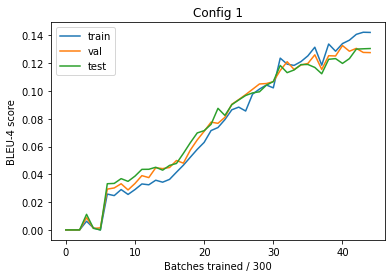

In [87]:
config = 1
plot_bleus['train'][config] = [all_histories[config-1]['train_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['train_bleu_history'].keys(), key=cmp_to_key(compare))]
plot_bleus['val'][config] = [all_histories[config-1]['val_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['val_bleu_history'].keys(), key=cmp_to_key(compare))]
plot_bleus['test'][config] = [all_histories[config-1]['test_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['test_bleu_history'].keys(), key=cmp_to_key(compare))]
plt.plot(plot_bleus['train'][config], label='train')
plt.plot(plot_bleus['val'][config], label='val')
plt.plot(plot_bleus['test'][config], label='test')
plt.xlabel('Batches trained / 300')
plt.ylabel('BLEU-4 score')
plt.title('Config 1')
plt.legend()

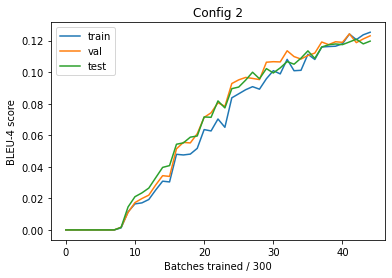

In [88]:
config = 2
plot_bleus['train'][config] = [all_histories[config-1]['train_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['train_bleu_history'].keys(), key=cmp_to_key(compare))]
plot_bleus['val'][config] = [all_histories[config-1]['val_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['val_bleu_history'].keys(), key=cmp_to_key(compare))]
plot_bleus['test'][config] = [all_histories[config-1]['test_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['test_bleu_history'].keys(), key=cmp_to_key(compare))]
plt.plot(plot_bleus['train'][config], label='train')
plt.plot(plot_bleus['val'][config], label='val')
plt.plot(plot_bleus['test'][config], label='test')
plt.xlabel('Batches trained / 300')
plt.ylabel('BLEU-4 score')
plt.title('Config 2')
plt.legend()

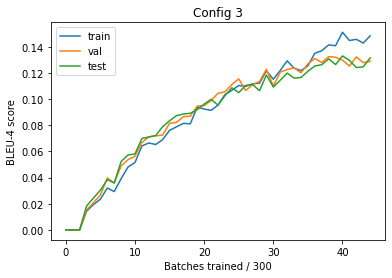

In [89]:
config = 3
plot_bleus['train'][config] = [all_histories[config-1]['train_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['train_bleu_history'].keys(), key=cmp_to_key(compare))]
plot_bleus['val'][config] = [all_histories[config-1]['val_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['val_bleu_history'].keys(), key=cmp_to_key(compare))]
plot_bleus['test'][config] = [all_histories[config-1]['test_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['test_bleu_history'].keys(), key=cmp_to_key(compare))]
plt.plot(plot_bleus['train'][config], label='train')
plt.plot(plot_bleus['val'][config], label='val')
plt.plot(plot_bleus['test'][config], label='test')
plt.xlabel('Batches trained / 300')
plt.ylabel('BLEU-4 score')
plt.title('Config 3')
plt.legend()

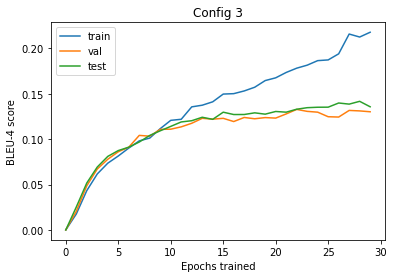

In [90]:
config = 3 #Long
train_3_bleus = [bleu['bleu'] for bleu in histories_3_long['train_bleu'].values()]
val_3_bleus = [bleu['bleu'] for bleu in histories_3_long['val_bleu'].values()]
test_3_bleus = [bleu['bleu'] for bleu in histories_3_long['test_bleu'].values()]
plt.plot(train_3_bleus, label='train')
plt.plot(val_3_bleus, label='val')
plt.plot(test_3_bleus, label='test')
plt.xlabel('Epochs trained')
plt.ylabel('BLEU-4 score')
plt.title('Config 3')
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


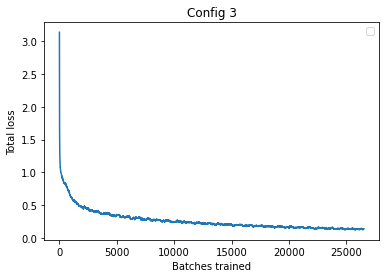

In [91]:
config = 3 #Long, running average of training loss
train_3_loss = [loss for loss in histories_3_long['total_loss'].values()]
window_width = 100
cumsum_vec = np.cumsum(np.insert(train_3_loss, 0, 0)) 
ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
plt.plot(ma_vec)
plt.xlabel('Batches trained')
plt.ylabel('Total loss')
plt.title('Config 3')
plt.legend()

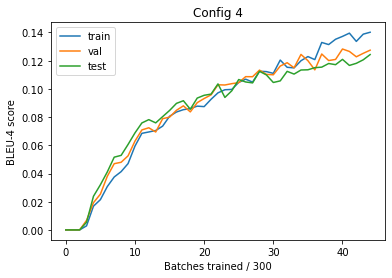

In [92]:
config = 4
train_4_bleus = [bleu['bleu'] for bleu in histories_4['train_bleu'].values()]
val_4_bleus = [bleu['bleu'] for bleu in histories_4['val_bleu'].values()]
test_4_bleus = [bleu['bleu'] for bleu in histories_4['test_bleu'].values()]
plt.plot(train_4_bleus, label='train')
plt.plot(val_4_bleus, label='val')
plt.plot(test_4_bleus, label='test')
plt.xlabel('Batches trained / 300')
plt.ylabel('BLEU-4 score')
plt.title('Config 4')
plt.legend()

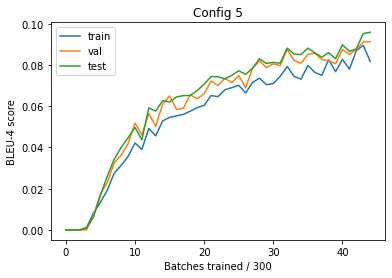

In [96]:
config = 5
train_5_bleus = [bleu['bleu'] for bleu in histories_5['train_bleu'].values()]
val_5_bleus = [bleu['bleu'] for bleu in histories_5['val_bleu'].values()]
test_5_bleus = [bleu['bleu'] for bleu in histories_5['test_bleu'].values()]
plt.plot(train_5_bleus, label='train')
plt.plot(val_5_bleus, label='val')
plt.plot(test_5_bleus, label='test')
plt.xlabel('Batches trained / 300')
plt.ylabel('BLEU-4 score')
plt.title('Config 5')
plt.legend()

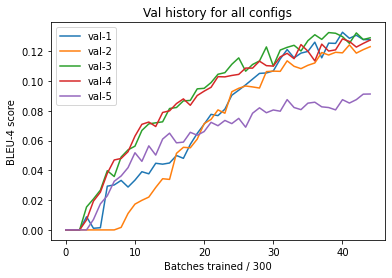

In [100]:
plt.plot(plot_bleus['val'][1], label='val-1')
plt.plot(plot_bleus['val'][2], label='val-2')
plt.plot(plot_bleus['val'][3], label='val-3')
plt.plot(val_4_bleus, label='val-4')
plt.plot(val_5_bleus, label='val-5')
plt.xlabel('Batches trained / 300')
plt.ylabel('BLEU-4 score')
plt.title('Val history for all configs')
plt.legend()

In [144]:
config=3
train_bleu1 = [all_histories[config-1]['train_bleu_history'][key]['precisions'][0] for key in sorted(all_histories[config-1]['train_bleu_history'].keys(), key=cmp_to_key(compare))]
val_bleu1 = [all_histories[config-1]['val_bleu_history'][key]['precisions'][0] for key in sorted(all_histories[config-1]['val_bleu_history'].keys(), key=cmp_to_key(compare))]
test_bleu1 = [all_histories[config-1]['test_bleu_history'][key]['precisions'][0] for key in sorted(all_histories[config-1]['test_bleu_history'].keys(), key=cmp_to_key(compare))]

train_bleu2 = [all_histories[config-1]['train_bleu_history'][key]['precisions'][1] for key in sorted(all_histories[config-1]['train_bleu_history'].keys(), key=cmp_to_key(compare))]
val_bleu2 = [all_histories[config-1]['val_bleu_history'][key]['precisions'][1] for key in sorted(all_histories[config-1]['val_bleu_history'].keys(), key=cmp_to_key(compare))]
test_bleu2 = [all_histories[config-1]['test_bleu_history'][key]['precisions'][1] for key in sorted(all_histories[config-1]['test_bleu_history'].keys(), key=cmp_to_key(compare))]

train_bleu3 = [all_histories[config-1]['train_bleu_history'][key]['precisions'][2] for key in sorted(all_histories[config-1]['train_bleu_history'].keys(), key=cmp_to_key(compare))]
val_bleu3 = [all_histories[config-1]['val_bleu_history'][key]['precisions'][2] for key in sorted(all_histories[config-1]['val_bleu_history'].keys(), key=cmp_to_key(compare))]
test_bleu3 = [all_histories[config-1]['test_bleu_history'][key]['precisions'][2] for key in sorted(all_histories[config-1]['test_bleu_history'].keys(), key=cmp_to_key(compare))]

train_bleu4 = [all_histories[config-1]['train_bleu_history'][key]['precisions'][3] for key in sorted(all_histories[config-1]['train_bleu_history'].keys(), key=cmp_to_key(compare))]
val_bleu4 = [all_histories[config-1]['val_bleu_history'][key]['precisions'][3] for key in sorted(all_histories[config-1]['val_bleu_history'].keys(), key=cmp_to_key(compare))]
test_bleu4 = [all_histories[config-1]['test_bleu_history'][key]['precisions'][3] for key in sorted(all_histories[config-1]['test_bleu_history'].keys(), key=cmp_to_key(compare))]

In [143]:
train_bleu1[np.argmax(plot_bleus['val'][3])], val_bleu1[np.argmax(plot_bleus['val'][3])], test_bleu1[np.argmax(plot_bleus['val'][3])]

(0.510577971646674, 0.47501594726770147, 0.4448034464189553)

In [145]:
train_bleu2[np.argmax(plot_bleus['val'][3])], val_bleu2[np.argmax(plot_bleus['val'][3])], test_bleu2[np.argmax(plot_bleus['val'][3])]

(0.3074663402692778, 0.2631453154875717, 0.24954351795496044)

In [146]:
train_bleu3[np.argmax(plot_bleus['val'][3])], val_bleu3[np.argmax(plot_bleus['val'][3])], test_bleu3[np.argmax(plot_bleus['val'][3])]

(0.20641562064156208, 0.17598908594815826, 0.16445066480055984)

In [147]:
train_bleu4[np.argmax(plot_bleus['val'][3])], val_bleu4[np.argmax(plot_bleus['val'][3])], test_bleu4[np.argmax(plot_bleus['val'][3])]

(0.15289925494007126, 0.13187162376866857, 0.12750205648478202)

In [149]:
plot_bleus['test'][3][np.argmax(plot_bleus['val'][3])]

0.13081483891898643

In [106]:
model = T5ForConditionalGeneration.from_pretrained(os.path.join(models_dir, '3', '14-600', 'model')).to(device)
frame_to_enc = torch.load(os.path.join(models_dir, '3', '14-600', 'frame_to_enc')).to(device)
enc_to_gloss_probs = torch.load(os.path.join(models_dir, '3', '14-600', 'enc_to_gloss_probs')).to(device)

In [108]:
test_batch = next(iter(phoenix_test_loader))
test_batch

[tensor([[[6.3695e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.7400e+00, 0.0000e+00, 0.0000e+00,  ..., 3.0390e-03,
           0.0000e+00, 0.0000e+00],
          [5.0131e+00, 0.0000e+00, 0.0000e+00,  ..., 1.2524e-01,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],
 
         [[0.0000e+00, 0.0000e+00, 3.5375e-01,  ..., 1.7852e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 8.2829e-01,  ..., 1.0190e+00,
           3.8638e-02, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 2.3845e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.000

In [110]:
model.eval()
sign, gloss, text = test_batch
sign = sign.to(device)
frame_embeds = frame_to_enc(sign.view(-1, 1024)).view(len(sign), 200, 512)
translations_ids = t5_tokenizer(list(text), return_tensors='pt', padding='max_length', max_length=200).input_ids.to(device)
outputs = model(inputs_embeds=frame_embeds, labels=translations_ids)

gloss_probs = enc_to_gloss_probs(outputs.encoder_last_hidden_state.view(-1, 512)).view(vid_batch_size, 200, vocab_size+1).permute(1, 0, 2)

In [111]:
gloss_probs.shape

torch.Size([200, 8, 32101])

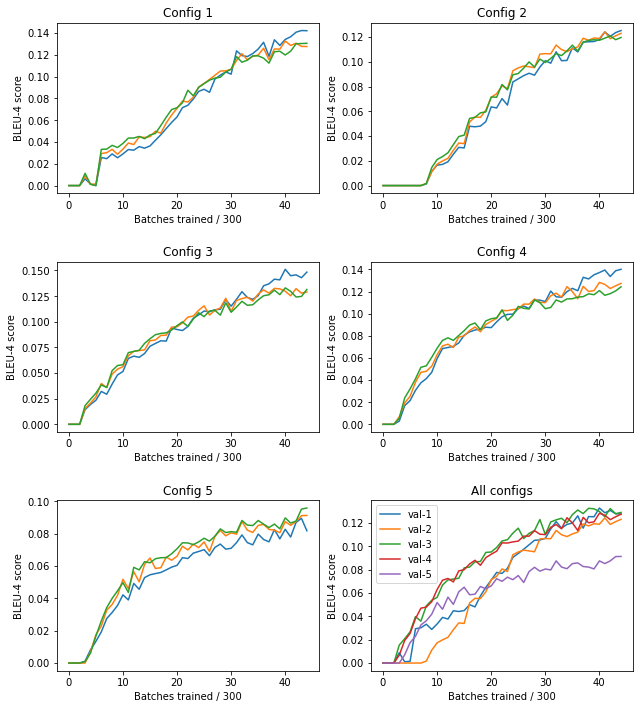

In [138]:
fig, axs = plt.subplots(3, 2)
config = 1
plot_bleus['train'][config] = [all_histories[config-1]['train_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['train_bleu_history'].keys(), key=cmp_to_key(compare))]
plot_bleus['val'][config] = [all_histories[config-1]['val_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['val_bleu_history'].keys(), key=cmp_to_key(compare))]
plot_bleus['test'][config] = [all_histories[config-1]['test_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['test_bleu_history'].keys(), key=cmp_to_key(compare))]
axs[0, 0].plot(plot_bleus['train'][config], label='train')
axs[0, 0].plot(plot_bleus['val'][config], label='val')
axs[0, 0].plot(plot_bleus['test'][config], label='test')
axs[0, 0].set(xlabel='Batches trained / 300', ylabel='BLEU-4 score', title='Config 1')

config = 2
plot_bleus['train'][config] = [all_histories[config-1]['train_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['train_bleu_history'].keys(), key=cmp_to_key(compare))]
plot_bleus['val'][config] = [all_histories[config-1]['val_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['val_bleu_history'].keys(), key=cmp_to_key(compare))]
plot_bleus['test'][config] = [all_histories[config-1]['test_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['test_bleu_history'].keys(), key=cmp_to_key(compare))]
axs[0, 1].plot(plot_bleus['train'][config], label='train')
axs[0, 1].plot(plot_bleus['val'][config], label='val')
axs[0, 1].plot(plot_bleus['test'][config], label='test')
axs[0, 1].set(xlabel='Batches trained / 300', ylabel='BLEU-4 score', title='Config 2')

config = 3
plot_bleus['train'][config] = [all_histories[config-1]['train_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['train_bleu_history'].keys(), key=cmp_to_key(compare))]
plot_bleus['val'][config] = [all_histories[config-1]['val_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['val_bleu_history'].keys(), key=cmp_to_key(compare))]
plot_bleus['test'][config] = [all_histories[config-1]['test_bleu_history'][key]['bleu'] for key in sorted(all_histories[config-1]['test_bleu_history'].keys(), key=cmp_to_key(compare))]
axs[1, 0].plot(plot_bleus['train'][config], label='train')
axs[1, 0].plot(plot_bleus['val'][config], label='val')
axs[1, 0].plot(plot_bleus['test'][config], label='test')
axs[1, 0].set(xlabel='Batches trained / 300', ylabel='BLEU-4 score', title='Config 3')

config = 4
train_4_bleus = [bleu['bleu'] for bleu in histories_4['train_bleu'].values()]
val_4_bleus = [bleu['bleu'] for bleu in histories_4['val_bleu'].values()]
test_4_bleus = [bleu['bleu'] for bleu in histories_4['test_bleu'].values()]
axs[1, 1].plot(train_4_bleus, label='train')
axs[1, 1].plot(val_4_bleus, label='val')
axs[1, 1].plot(test_4_bleus, label='test')
axs[1, 1].set(xlabel='Batches trained / 300', ylabel='BLEU-4 score', title='Config 4')

config = 5
train_5_bleus = [bleu['bleu'] for bleu in histories_5['train_bleu'].values()]
val_5_bleus = [bleu['bleu'] for bleu in histories_5['val_bleu'].values()]
test_5_bleus = [bleu['bleu'] for bleu in histories_5['test_bleu'].values()]
axs[2, 0].plot(train_5_bleus, label='train')
axs[2, 0].plot(val_5_bleus, label='val')
axs[2, 0].plot(test_5_bleus, label='test')
axs[2, 0].set(xlabel='Batches trained / 300', ylabel='BLEU-4 score', title='Config 5')

axs[2, 1].plot(plot_bleus['val'][1], label='val-1')
axs[2, 1].plot(plot_bleus['val'][2], label='val-2')
axs[2, 1].plot(plot_bleus['val'][3], label='val-3')
axs[2, 1].plot(val_4_bleus, label='val-4')
axs[2, 1].plot(val_5_bleus, label='val-5')
axs[2, 1].set(xlabel='Batches trained / 300', ylabel='BLEU-4 score', title='All configs')
axs[2, 1].legend()

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.2, 
                    hspace=0.4)
fig.set_figheight(10)
fig.set_figwidth(10)